# Rolling Qutarerly NDVI climatology
Notebook is only compatible on the `NCI` as it uses Landsat Collection 2

In [11]:
import xarray as xr
from datacube.helpers import write_geotiff
import datacube
import matplotlib.pyplot as plt
from dask.distributed import Client
import geopandas as gpd
import sys
import os
sys.path.append('src')
from anomalies import calculate_anomalies, load_landsat, display_map, map_shapefile
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# jbw notes
NMDB tifs are 3-5GB each.
rolling 3-month NSW will require 12 mean and 12 std tiles of potentially 5gb each

### Set up local dask cluster

Dask will create a local cluster of cpus for running this analysis in parallel. If you'd like to see what the dask cluster is doing, click on the hyperlink that prints after you run the cell and you can watch the cluster run.

In [2]:
#delete old client if one still exists
client = locals().get('client', None)
if client is not None:
    client.close()
    del client
    
client = Client(n_workers=3, threads_per_worker=1, memory_limit='9GB')
client

Client Scheduler: tcp://127.0.0.1:36599 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 3 Cores: 3 Memory: 27.00 GB


In [3]:
#input parameters

#NSW shapefile vs bounding box - speed?
#nsw bounding box
# latitude_range = (-37.53, -28.15)
# longitude_range = (140.99, 153.66)

#orange
latitude_range = ( -33.5, -33)
longitude_range = (148.5, 149.5)
time = ('1987', '2012')

#dask chunk size, shouldn't need to change
chunk_size = 750

In [4]:
# jbw - remove in final as bounding box will be all of NSW or NSW bounding box
# If your specifying a lat, lon and buffer, run this cell
display_map(y=(latitude_range), x=(longitude_range))

In [5]:
dc = datacube.Datacube(app='longterm-ndvi-anomaly')

query = {'lon': longitude_range,
                 'lat': latitude_range,
                 'time': time}

ds = load_landsat(dc=dc, query=query, sensors=['ls5','ls7','ls8'], 
                  bands_of_interest=['nir', 'red'], lazy_load=True,
                  dask_chunks = {'x': chunk_size, 'y': chunk_size})
ds


Loading ls5
Loading ls7
Loading ls8
    Skipping ls8; no valid data for query
Combining and sorting ls5, ls7 data


<xarray.Dataset>
Dimensions:  (time: 783, x: 3967, y: 2705)
Coordinates:
  * x        (x) float64 1.519e+06 1.519e+06 1.519e+06 ... 1.619e+06 1.619e+06
  * y        (y) float64 -3.698e+06 -3.698e+06 ... -3.765e+06 -3.765e+06
  * time     (time) datetime64[ns] 1987-05-29T23:14:05.500000 ... 2011-11-14T23:43:32
Data variables:
    nir      (time, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
    red      (time, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
Attributes:
    crs:      EPSG:3577

In [30]:
def compute_climatology(
        data, quarter):  # add back to ndvi_rolling_climatology as function?

    quarter_dict = {
        'JFM': [1, 2, 3],
        'FMA': [2, 3, 4],
        'MAM': [3, 4, 5],
        'AMJ': [4, 5, 6],
        'MJJ': [5, 6, 7],
        'JJA': [6, 7, 8],
        'JAS': [7, 8, 9],
        'ASO': [8, 9, 10],
        'SON': [9, 10, 11],
        'OND': [10, 11, 12],
        'NDJ': [11, 12, 1],
        'DJF': [12, 1, 2],
    }
    #better to remove this from function to avoid redundancy in loop?
    #calculate ndvi
    ndvi = (data.nir - data.red) / (data.nir + data.red)
    ndvi = ndvi.astype('float32')  #convert to reduce memory

    #modified from anomalies - return to function with input season? JFM=1,2,3 or just numeric loop
    #calculate climatologies

    #fixme - return to function, default behaviour - run both mean and std?
    #fixme - add crs attribute to zarr?

    ix = ndvi['time.month'].isin(quarter_dict[quarter])

    ndvi_clim_mean = ndvi[ix].mean(dim='time')
    ndvi_clim_mean = ndvi_clim_mean.rename('ndvi_clim_mean').to_dataset()
    ndvi_clim_mean.attrs = data.attrs
    ndvi_clim_mean.to_zarr('results/NSW_ndvi_clim_mean_' + quarter + '.nc')

    ndvi_clim_stdev = ndvi[ix].std(dim='time')
    ndvi_clim_stdev = ndvi_clim_stdev.rename('ndvi_clim_stdev').to_dataset()
    ndvi_clim_stdev.attrs = data.attrs
    ndvi_clim_stdev.to_zarr('results/NSW_ndvi_clim_stdev_' + quarter + '.nc')

In [33]:
ds.attrs

{'crs': CRS('EPSG:3577')}

In [31]:
# run for one quarter
compute_climatology(ds,'OND')

TypeError: Invalid value for attr: EPSG:3577 must be a number, a string, an ndarray or a list/tuple of numbers/strings for serialization to netCDF files

In [25]:
data=xr.open_zarr('./results/ndvi_clim_mean_OND.nc')

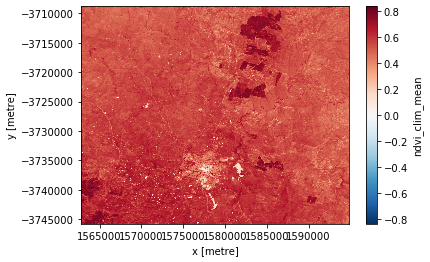

In [71]:
#in a loop
for q in quarter_dict:
    compute_climatology(ds,q)


ValueError: path '' contains a group